In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import random

# Base de dados

In [2]:
df = pd.read_excel('../Base120.xlsx')

In [3]:
def filtra_por_solucao(df, vet_solucao):
    '''Recebe um vetor solução e retorna o df filtrado para essa solução'''
    stand_prescription_map = {i + 1: vet_solucao[i] for i in range(len(vet_solucao))}
    filtered_df = df[df.apply(lambda row: row['prescrição'] == stand_prescription_map.get(row['talhao']), axis=1)]
    return filtered_df

def calcula_volume(result):
	"""
	Calculate the volume by summing specific columns of a DataFrame.
	This function takes a DataFrame `result` and returns the sum of the values
	in columns 3 to 18 (inclusive).
	Parameters:
	result (pandas.DataFrame): The input DataFrame containing the data.
	Returns:
	pandas.Series: A Series containing the sum of the specified columns.
	"""
	
    
	return result.iloc[:, 3:19].sum()

def calcula_penalidade(volume_anual):
    '''retorna penalidade por volume excedente/faltante (R$500)'''
    upper = []
    lower = []
    for v_ano in volume_anual:
        if v_ano < 140000:
            lower.append(np.abs(v_ano - 140000))
        elif v_ano > 160000:
            upper.append(np.abs(v_ano - 160000))
    return np.sum(upper + lower)*500

def calcula_vpl_aux(result, volume_ano):
    '''Calcula o VPL penalizado (função auxiliar)'''
    return np.sum(result['VPL']) - calcula_penalidade(volume_ano)

def plota_volume(df, vet_sol):
    '''Plota o gráfico do volume nos anos'''
    volume_ano = filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()
    (volume_ano/1000).plot(kind='bar')
    plt.hlines(140, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.hlines(160, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.title("Volume de madeira por ano")
    plt.xlabel("Ano de Produção")
    plt.ylabel("Volume (1000 m$^3$)")

def calcula_volume_aux(df, vet_sol):
	"""
	Calculate the auxiliary volume based on the given solution vector.
	This function filters the DataFrame `df` using the solution vector `vet_sol`
	and then sums the values in columns 3 to 18 (inclusive) of the filtered DataFrame.
	Parameters:
	df (pandas.DataFrame): The input DataFrame containing the data.
	vet_sol (list or array-like): The solution vector used to filter the DataFrame.
	Returns:
	pandas.Series: A Series containing the sum of the values in columns 3 to 18 of the filtered DataFrame.
	"""
    
	return filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()

def calcula_vpl_total(df, vet_solucao):
    '''Calcula o VPL total penalizado'''
    result = filtra_por_solucao(df, vet_solucao)
    volume_ano = calcula_volume(result)
    return calcula_vpl_aux(result, volume_ano)

def encontra_pior_ano(df, sol):
    volume_ano = calcula_volume_aux(df, sol)
    return np.argmax(np.abs(volume_ano-160000)) + 1

def numpy_to_python(obj):
    '''Converte np.int e np.float para int e float dos dados do dicionário'''
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    
def python_to_numpy(dicionario):
    '''Converte int e float para np.int e np.float dos dados do dicionário'''
    for chave, subdict in dicionario.items():
        for subchave, valor in subdict.items():
            if isinstance(valor, int):
                subdict[subchave] = np.int64(valor)
            elif isinstance(valor, float):
                subdict[subchave] = np.float64(valor)
                
    dicionario = {np.int64(key): valor for key, valor in dicionario.items()}
    return dicionario

---

## Alteração na base de dados

In [4]:
df_2 = df.drop_duplicates(subset=['talhao'] + df.columns[3:].tolist(), keep='first')
df_2.to_csv('../base_reduzida.csv', index=False)

---

# Algoritmo Genético

## Soluções importadas


In [5]:
with open("../solucoes_alpha.json", "r") as arquivo: # soluções geradas por heurística construtiva
    solucoes_alpha = json.load(arquivo)
solucoes_alpha = [np.array(sol) for sol in solucoes_alpha]

In [6]:
class solucao:
    def __init__(self, sol):
        self.sol = sol
        self.vpl = calcula_vpl_total(df_2, self.sol)
        global count_func_obj
        count_func_obj += 1
    
    def recalcula_vpl(self) -> None:
        self.vpl = calcula_vpl_total(df_2, self.sol)
        global count_func_obj
        count_func_obj += 1

In [121]:
# ok
def set_seed(seed_value=42) -> None:
    np.random.seed(seed_value)
    random.seed(seed_value)

# ok
def gera_populacao_inicial(n_pop, n_talhoes=120, perc_aleatoria=0.8) -> list[solucao]:
    
    global melhor_global
    populacao = [solucao(sol) for sol in np.random.randint(1, 121, size=(round(n_pop*perc_aleatoria), n_talhoes))]  # pop aleatória
    melhor_sol = solucoes_alpha[2]
    
    for _ in range(n_pop-round(n_pop*perc_aleatoria)): # quantidade soluções semi boas
        sol = np.copy(melhor_sol)
        random.shuffle(sol) # embaralha solução semi boa
        populacao.append(solucao(sol))
        
    melhor_global = max(populacao, key=lambda sol: sol.vpl)
    return populacao

# ok* (prob cruzamento)
def selecao(populacao, metodo='torneio') -> np.ndarray[solucao]:
    
    pares = np.array([[],[]])
    tam_torneio = 0.15

    # olhar probabilidade de cruzamento!!!
    for _ in range(round(len(populacao) / 2)): # quantidade de pares
        populacao_aux = populacao.copy()
        pop_torneio1 = random.sample(populacao_aux, round(len(populacao_aux) * tam_torneio))
        p1 = max(pop_torneio1, key=lambda sol_torneio: sol_torneio.vpl)
        populacao_aux.remove(p1)
        
        pop_torneio2 = random.sample(populacao_aux, round(len(populacao_aux) * tam_torneio))
        p2 = max(pop_torneio2, key=lambda sol_torneio: sol_torneio.vpl)
        pares = np.append(pares, [[p1], [p2]])
        
    return pares.reshape(round(len(populacao)/2), 2)

# ok* (só 1 crossover)
def recombinacao(pares, prob_mutacao) -> list[solucao]:
    
    global melhor_global
    filhos = []
    
    for pai1, pai2 in pares:
        pontos_crossover = [round(len(pares[0][0].sol) * random.random()) for _ in range(2)] # deixar apenas um crossover
        pontos_crossover.sort()
        crossover1 = pontos_crossover[0]
        # crossover2 = pontos_crossover[1]
        
        filho1 = solucao(np.concatenate((pai1.sol[:crossover1], 
                                         pai2.sol[crossover1:])))
        
        filho2 = solucao(np.concatenate((pai2.sol[:crossover1], 
                                         pai1.sol[crossover1:])))
        
        # filho1 = solucao(np.concatenate((pai1.sol[:crossover1], 
        #                                  pai2.sol[crossover1:crossover2], 
        #                                  pai1.sol[crossover2:])))
        
        # filho2 = solucao(np.concatenate((pai2.sol[:crossover1], 
        #                                  pai1.sol[crossover1:crossover2], 
        #                                  pai2.sol[crossover2:])))
        
        melhor_global = max(melhor_global, filho1, filho2, key=lambda aux: aux.vpl) # atualiza melhor_solucao antes da mutação
        if random.random() < prob_mutacao:
            mutacao(filho1)
            melhor_global = max(melhor_global, filho1, key=lambda aux: aux.vpl) # atualiza melhor_solucao após mutação
        if random.random() < prob_mutacao:
            mutacao(filho2)
            melhor_global = max(melhor_global, filho2, key=lambda aux: aux.vpl) # atualiza melhor_solucao após mutação
        
        filhos.append(filho1)
        filhos.append(filho2)
    return filhos

# ok
def mutacao(filho) -> None:
    talhoes_sorteados = [random.randrange(1, 121) for _ in range(2)]
    filho.sol[talhoes_sorteados[0]-1], filho.sol[talhoes_sorteados[1]-1] = filho.sol[talhoes_sorteados[1]-1], filho.sol[talhoes_sorteados[0]-1] # swap
    filho.recalcula_vpl()

# ok
def substituicao(pais, filhos, prop_elite=0.2) -> list[solucao]:
    ''' Mantem prop_elite% dos melhores pais mais o restante dos filhos aleatórios '''
    
    n_elite = int(prop_elite * len(pais))
    pais_elite = pais.copy()
    pais_elite.sort(key=lambda sol_torneio: sol_torneio.vpl, reverse=True)
    if melhor_global in filhos:
        filhos.remove(melhor_global)
        return pais_elite[:n_elite] + random.sample(filhos, len(pais) - n_elite - 1) + [melhor_global]
    return pais_elite[:n_elite] + random.sample(filhos, len(pais) - n_elite)

def calcula_estatisticas(populacao, estatisticas) -> dict:
    lista_vpl = [sol.vpl for sol in populacao]
    estatisticas['avg'].append(np.mean(lista_vpl))
    estatisticas['std'].append(np.std(lista_vpl))
    estatisticas['max'].append(np.max(lista_vpl))
    estatisticas['min'].append(np.min(lista_vpl))


In [34]:
set_seed(48)
count_func_obj = 0
melhor_global = None

p = gera_populacao_inicial(5)
# for i in p:
#     print(i.vpl)
#     print(i.sol, '\n')
# print('-----\n')

sel = selecao(p)

rec = recombinacao(sel, 0.01)
# for i in rec:
#     print(i.vpl)
#     print(i.sol, '\n')
# print('-----\n')

p = substituicao(p, rec)    
# for i in p:
    # print(i.vpl)
    # print(i.sol, '\n')
print(melhor_global.sol)
print(melhor_global.vpl, '\n')

[ 55 102 102  91  44  91  10  10  30 115  75  49  89 108 109 107 105  70
  87  56   7  81   1  13  36  64  22  18  39  91  99  50   8  86  45 105
  57  18  65   1   3  34  60  93  33  37  93   5  69  17  36  29  73   6
 119 106  20  65  76   2 117  23  89 116 115  68  49  67  62  46  21 119
  55  87 104  47  43   1  48  24 105  93  48  20  23  26 117  76  31  13
 110  46   3  28  15  41  46  30  31  43  65  49  69  17 112  49  66 115
  31  74  90  12  69 103  56  81  94  16 116  20]
-777265977 



In [144]:
set_seed(41)
a = []
for _ in range(1): # num de experimentos
    melhor_global = None
    count_func_obj = 0
    estatisticas = {'avg':[], 'std':[], 'max':[], 'min':[]} # estatísticas da população
    populacao = gera_populacao_inicial(40, perc_aleatoria=0.02) # pais
    
    while count_func_obj < 100000: # num de avaliações de função objetivo
    # for _ in range(500): # num de gerações
        calcula_estatisticas(populacao, estatisticas)
        pares = selecao(populacao)
        filhos = recombinacao(pares, prob_mutacao=0.01)
        populacao = substituicao(populacao, filhos, prop_elite=0.25)
        a.append(melhor_global.vpl)

29666212.0


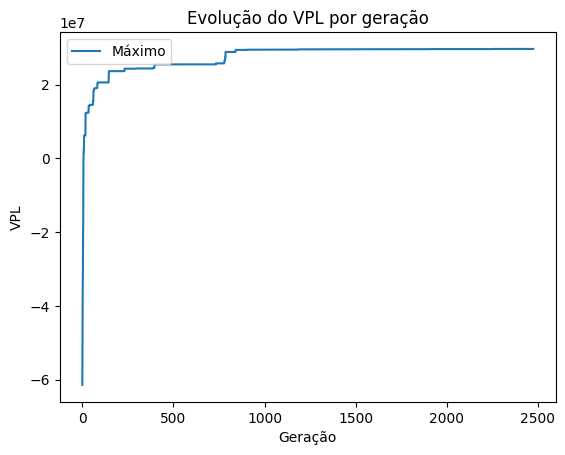

In [146]:
print(melhor_global.vpl)

# plt.plot(estatisticas['avg'], label='Média')
plt.plot(estatisticas['max'], label='Máximo')
# plt.plot(a, label='Melhor VPL')
# plt.plot(estatisticas['min'], label='Mínimo')

plt.title("Evolução do VPL por geração")
plt.xlabel("Geração")
plt.ylabel("VPL")
plt.legend()